<h1><center>Analysis of Life Expectancy Data</center></h1>
<h3><center>Evan Nadelbach and Joseph Zietowski</center></h3>

### Importance of Global Health
The world's ongoing fight against Covid-19 makes it very clear that global health is of the utmost importance for the future of humanity, and as the world continues to become more and more physically connected, the importance of global health will continue to skyrocket. It is a misconception that global health doesn't affect everyone, especially those already living in "healthy" countries with access to good education and medicine. Global health is often described as a security issue, but it is also a political issue and even an economic issue. Ultimately, due to how fast diseases and ideas can spread, global health quickly turns into everyone’s issue. Improving global health and the well-being of all people is no easy task due to the extensive variation among populations, but, just like in any other complicated question, narrowing down the fundamental problem can help bring to light the real factors in play. In order make the problem as specific as possible, it is necessary to break it into smaller, easier problems that pertain to specific populations. To do this, we must first understand how to measure global health, and although there are countless factors, life expectancy is a great place to start due to its objectiveness and universality.

### What is life expectancy?
Life expectancy statistics may seem self explanatory, but there are actually many different ways of measuring life expectancy, and some of them are biased more than others.

### Purpose
purpose


<h2>Data Collection</h2>

All the data we are using comes from the <a href="https://www.who.int/">World Health Orginazation</a>, a United Nations agency that specializes in international public health. We decided to choose a wide variety of factors 

In [336]:
import pandas as pd
import re
from sklearn import linear_model
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_rows', None)

In [337]:
# read in the life expectancy data
# https://apps.who.int/gho/data/view.main.SDG2016LEXv?lang=en
df = pd.read_csv("data/life_expectancy.csv")
df.head()

Country  Year  Life expectancy at birth (years) (Both sexes)  \
0  Afghanistan  2016                                           62.7   
1  Afghanistan  2015                                           63.2   
2  Afghanistan  2014                                           63.0   
3  Afghanistan  2013                                           62.7   
4  Afghanistan  2012                                           62.2   

   Life expectancy at birth (years) (Male)  \
0                                     61.0   
1                                     61.8   
2                                     61.7   
3                                     61.5   
4                                     60.9   

   Life expectancy at birth (years) (Female)  \
0                                       64.5   
1                                       64.7   
2                                       64.4   
3                                       64.1   
4                                       63.6   

   Life expectancy at age 60 (years) (Both sexes)  \
0                                            16.3   
1                                            16.3   
2                                            16.2   
3                                            16.2   
4                                            16.1   

   Life expectancy at age 60 (years) (Male)  \
0                                      15.5   
1                                      15.5   
2                                      15.4   
3                                      15.4   
4                                      15.3   

   Life expectancy at age 60 (years) (Female)  \
0                                        17.1   
1                                        17.1   
2                                        17.0   
3                                        16.9   
4                                        16.8   

   Healthy life expectancy (HALE) at birth (years) (Both sexes)  \
0                                               53.0              
1                                               53.2              
2                                                NaN              
3                                                NaN              
4                                                NaN              

   Healthy life expectancy (HALE) at birth (years) (Male)  \
0                                               52.1        
1                                               52.6        
2                                                NaN        
3                                                NaN        
4                                                NaN        

   Healthy life expectancy (HALE) at birth (years) (Female)  \
0                                               54.1          
1                                               54.1          
2                                                NaN          
3                                                NaN          
4                                                NaN          

   Healthy life expectancy (HALE) at age 60 (years) (Both sexes)  \
0                                               11.3               
1                                               11.2               
2                                                NaN               
3                                                NaN               
4                                                NaN               

   Healthy life expectancy (HALE) at age 60 (years) (Male)  \
0                                               10.9         
1                                               10.8         
2                                                NaN         
3                                                NaN         
4                                                NaN         

   Healthy life expectancy (HALE) at age 60 (years) (Female)  
0                                               11.7          
1                                               11.6        

In [338]:
# remove the unwanted columns
df = df[["Country", "Year", "Life expectancy at birth (years) (Both sexes)"]]

# rename the columns
df = df.rename(columns={"Life expectancy at birth (years) (Both sexes)": "life_expectancy", \
                        "Country" : "country", "Year" : "year"})

# remove the rows that are not needed (year > 2016)
df.drop(df[df.year >= 2017].index, inplace=True)
len(df)

3111

### Add the BMI data (Age-standardized mean BMI (kg/m^2) 18+ years old)

In [339]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/mean-bmi-(kg-m-)-(age-standardized-estimate)
bmi = pd.read_csv("data/bmi.csv")

# drop the unwanted columns
bmi.drop('Indicator',axis=1,inplace=True)
bmi.drop('Dim2',axis=1,inplace=True)

# drop the unwanted rows
bmi.drop(bmi[bmi.Period < 2000].index, inplace=True)
bmi.drop(bmi[bmi.Dim1 == "Male"].index, inplace=True)
bmi.drop(bmi[bmi.Dim1 == "Female"].index, inplace=True)

# tidy the data in the bmi column
bmi["First Tooltip"].replace(["No data"], np.nan, inplace=True)
bmi["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)
bmi["First Tooltip"] = bmi["First Tooltip"].astype(float)

# Mean imputation
bmi_mean = round(bmi.groupby('Period', as_index=False)['First Tooltip'].mean(), 1)

# merge the data into our life expectancy dataframe
df = df.merge(bmi, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)
df.drop('Dim1', axis=1, inplace=True)

# rename the BMI column
df = df.rename(columns={"First Tooltip": "bmi"})

for index, row in df.iterrows():
    if (str(row['bmi']) == "nan"):
        df.at[index, 'bmi'] = bmi_mean.loc[bmi_mean['Period'] == row['year']]['First Tooltip']

len(df)

3111

### Add the drinking-water data (% of population using at least basic drinking-water services)

In [340]:
import matplotlib.pyplot as plt

# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/population-using-safely-managed-drinking-water-services-(-)
drinking_water = pd.read_csv("data/drinking_water.csv")

# drop unwanted rows
indicator = "Population using at least basic drinking-water services (%)"
drinking_water.drop(drinking_water[drinking_water.Indicator != indicator].index, inplace=True)

# drop unwanted columns
drinking_water.drop("Indicator", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in drinking_water['Location'].unique():
    
    # Get only the data for the current country.
    currdata = drinking_water.loc[drinking_water['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            drinking_water = drinking_water.append({'Location': i, 'Period': k, \
                                                    'First Tooltip': round(reg.predict([[k]])[0], 2)}, ignore_index=True)


# merge the data into our life expectancy dataframe
df = df.merge(drinking_water, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the drinking-water column
df = df.rename(columns={"First Tooltip": "drinking_water"})

len(df)

3111

### Add the government expenditure data (% of government expenditure on general health)

In [341]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/general-government-expenditure-on-health-as-a-percentage-of-total-government-expenditure
government_expenditure = pd.read_csv("data/government_expenditure.csv")

# drop unwanted columns
government_expenditure.drop("Indicator", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in government_expenditure['Location'].unique():
    
    # Get only the data for the current country.
    currdata = government_expenditure.loc[government_expenditure['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            government_expenditure = government_expenditure.append({'Location': i, \
                                                                    'Period': k, \
                                                                    'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                                                   ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(government_expenditure, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the government expenditure column
df = df.rename(columns={"First Tooltip": "government_expenditure"})

len(df)

3111

### Add the HIV data (New HIV infections per 1000 uninfected population)

In [342]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/new-hiv-infections-(per-1000-uninfected-population)
HIV = pd.read_csv("data/HIV.csv")

# drop unwanted rows
HIV.drop(HIV[HIV.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted columns
HIV.drop("Indicator", axis=1, inplace=True)
HIV.drop("Dim1", axis=1, inplace=True)

# tidy the data in the HIV column
HIV["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)
HIV["First Tooltip"].replace(["<"], "", inplace=True, regex=True)
HIV.drop(HIV[HIV['First Tooltip'] == "No data"].index, inplace=True)

# HIV["First Tooltip"].replace(["No data"], np.nan, inplace=True)
HIV['First Tooltip'] = HIV['First Tooltip'].astype(float)

# This loop will iterate for each country in the dataset
for i in HIV['Location'].unique():
    
    # Get only the data for the current country.
    currdata = HIV.loc[HIV['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            HIV = HIV.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(HIV, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the HIV column
df = df.rename(columns={"First Tooltip": "HIV"})

len(df)

3111

### Add the homicide data (Estimates of rates of homicides per 100 000 population)

In [343]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/estimates-of-rates-of-homicides-per-100-000-population
homicides = pd.read_csv("data/homicides.csv")

# drop unwanted rows
homicides.drop(homicides[homicides.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted columns
homicides.drop("Indicator", axis=1, inplace=True)
homicides.drop("Dim1", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in homicides['Location'].unique():
    
    # Get only the data for the current country.
    currdata = homicides.loc[homicides['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            homicides = homicides.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(homicides, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the homicides column
df = df.rename(columns={"First Tooltip": "homicides"})

len(df)

3111

### Add the malaria data (Malaria incidence per 1000 population at risk)

In [344]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/malaria-incidence-(per-1-000-population-at-risk)
malaria = pd.read_csv("data/malaria.csv")

# drop unwanted columns
malaria.drop("Indicator", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in malaria['Location'].unique():
    
    # Get only the data for the current country.
    currdata = malaria.loc[malaria['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            malaria = malaria.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(malaria, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the malaria column
df = df.rename(columns={"First Tooltip": "malaria"})

df["malaria"].fillna(0, inplace=True)

len(df)

3111

### Add the pollution data (% of population with primary reliance on clean fuels and technologies)

In [345]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/gho-phe-primary-reliance-on-clean-fuels-and-technologies-proportion
pollution = pd.read_csv("data/pollution.csv")

# drop unwanted columns
pollution.drop("Indicator", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in pollution['Location'].unique():
    
    # Get only the data for the current country.
    currdata = pollution.loc[pollution['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            pollution = pollution.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(pollution, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the government expenditure column
df = df.rename(columns={"First Tooltip": "pollution"})

len(df)

3111

### Add the suicide data (Age-standardized suicide rates per 100,000 population)

In [346]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/age-standardized-suicide-rates-(per-100-000-population)
suicides = pd.read_csv("data/suicide.csv")

# drop unwanted rows
suicides.drop(suicides[suicides.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted columns
suicides.drop("Indicator", axis=1, inplace=True)
suicides.drop("Dim1", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in suicides['Location'].unique():
    
    # Get only the data for the current country.
    currdata = suicides.loc[suicides['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            suicides = suicides.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 1)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(suicides, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the suicides column
df = df.rename(columns={"First Tooltip": "suicides"})

len(df)

3111

### Add the tuberculosis data (Deaths due to tuberculosis among HIV-negative people per 100,000 population)

In [347]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/deaths-due-to-tuberculosis-among-hiv-negative-people-(per-100-000-population)
tuberculosis = pd.read_csv("data/tuberculosis.csv")

# drop unwanted column
tuberculosis.drop("Indicator", axis=1, inplace=True)

# tidy the data in the tuberculosis column
tuberculosis["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)

tuberculosis["Location"].replace(["Sudan \(until 2011\)"], "Sudan", inplace=True, regex=True)

# This loop will iterate for each country in the dataset
for i in tuberculosis['Location'].unique():
    
    # Get only the data for the current country.
    currdata = tuberculosis.loc[tuberculosis['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            tuberculosis = tuberculosis.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 1)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(tuberculosis, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the tuberculosis column
df = df.rename(columns={"First Tooltip": "tuberculosis"})

len(df)

3111

### Add the under-five deaths data (Number of under-five deaths in thousands)

In [348]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/number-of-under-five-deaths-(thousands)
under_five_deaths = pd.read_csv("data/under_five_deaths.csv")

# drop unwanted rows
under_five_deaths.drop(under_five_deaths[under_five_deaths.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted column
under_five_deaths.drop("Indicator", axis=1, inplace=True)
under_five_deaths.drop("Dim1", axis=1, inplace=True)

# tidy the data in the tuberculosis column
under_five_deaths["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)
under_five_deaths["Location"].replace(["Sudan \(until 2011\)"], "Sudan", inplace=True, regex=True)

# This loop will iterate for each country in the dataset
for i in under_five_deaths['Location'].unique():
    
    # Get only the data for the current country.
    currdata = under_five_deaths.loc[under_five_deaths['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            under_five_deaths = under_five_deaths.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 1)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(under_five_deaths, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the under five deaths column
df = df.rename(columns={"First Tooltip": "under_five_deaths"})

len(df)

3111

In [349]:
df

country  year  \
0                                           Afghanistan  2016   
1                                           Afghanistan  2015   
2                                           Afghanistan  2014   
3                                           Afghanistan  2013   
4                                           Afghanistan  2012   
5                                           Afghanistan  2011   
6                                           Afghanistan  2010   
7                                           Afghanistan  2009   
8                                           Afghanistan  2008   
9                                           Afghanistan  2007   
10                                          Afghanistan  2006   
11                                          Afghanistan  2005   
12                                          Afghanistan  2004   
13                                          Afghanistan  2003   
14                                          Afghanistan  2002   
15                                          Afghanistan  2001   
16                                          Afghanistan  2000   
17                                              Albania  2016   
18                                              Albania  2015   
19                                              Albania  2014   
20                                              Albania  2013   
21                                              Albania  2012   
22                                              Albania  2011   
23                                              Albania  2010   
24                                              Albania  2009   
25                                              Albania  2008   
26                                              Albania  2007   
27                                              Albania  2006   
28                                              Albania  2005   
29                                              Albania  2004   
30                                              Albania  2003   
31                                              Albania  2002   
32                                              Albania  2001   
33                                              Albania  2000   
34                                              Algeria  2016   
35                                              Algeria  2015   
36                                              Algeria  2014   
37                                              Algeria  2013   
38                                              Algeria  2012   
39                                              Algeria  2011   
40                                              Algeria  2010   
41                                              Algeria  2009   
42                                              Algeria  2008   
43                                              Algeria  2007   
44                                              Algeria  2006   
45                                              Algeria  2005   
46                                              Algeria  2004   
47                                              Algeria  2003   
48                                              Algeria  2002   
49                                              Algeria  2001   
50                                              Algeria  2000   
51                                               Angola  2016   
52                                               Angola  2015   
53                                               Angola  2014   
54                                               Angola  2013   
55                                               Angola  2012   
56                                               Angola  2011   
57                                               Angola  2010   
58                                               Angola  2009   
59                                               Angola  2008   
60                                               Angola  2007   
61                

In [350]:
# https://scikit-learn.org/stable/modules/impute.html

imputer = KNNImputer(n_neighbors=2, weights="uniform")
dftemp = imputer.fit_transform(df.values[:, 1:])
dftemp = pd.DataFrame(dftemp)
dftemp.insert(0, "country", df["country"], True)

dftemp.columns = ['country', 'year', 'life_expectancy', 'bmi', 'drinking_water', 'government_expenditure', 'HIV', \
                 'homicides', 'malaria', 'pollution', 'suicides', 'tuberculosis', 'under_five_deaths']

dftemp['year'] = dftemp['year'].astype(int)
df = dftemp

# Exploratory Data Analysis and Data Visualization

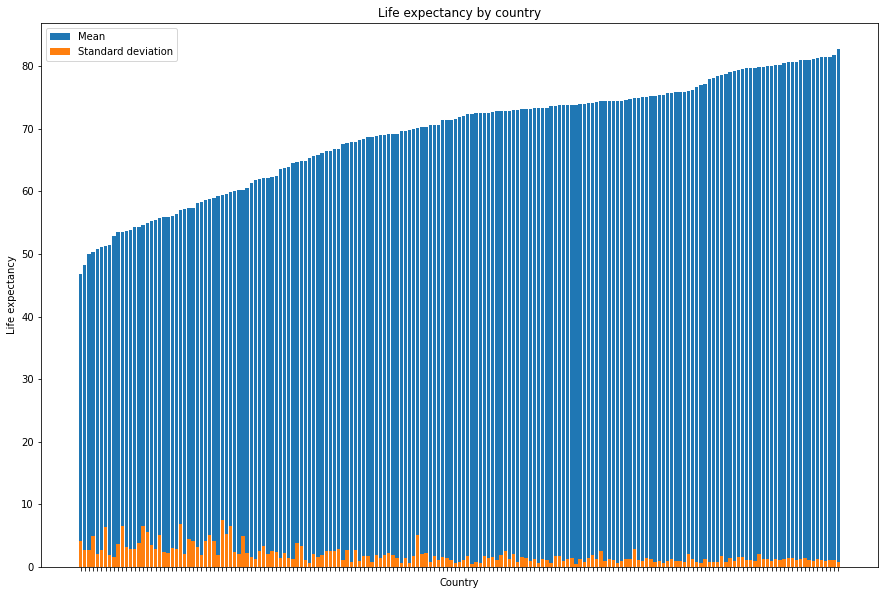

In [351]:
# Labels the x and y axes and sets the size of the plot
plt.figure(figsize=(15, 10))
plt.title('Life expectancy by country')
plt.xlabel('Country')
plt.ylabel('Life expectancy')

# Creates a dataset that computes the mean and standard deviation of the life expectancy for each country
# and merges the two values into one table
life_exp_mean = df.groupby('country', as_index=False)['life_expectancy'].mean()
life_exp_std = df.groupby('country', as_index=False)['life_expectancy'].std()
life_exp = life_exp_mean.merge(life_exp_std, how="outer", left_on = ["country"],  right_on = ["country"])

# Renames columns to have more recognizable names
life_exp = life_exp.rename(columns={"life_expectancy_x": "mean", "life_expectancy_y": "stdev"})

# Sorts based on mean
life_exp.sort_values('mean', inplace=True)

# Plots the bar graph shown below
plt.bar(x=life_exp['country'], height=life_exp['mean'], tick_label='')
plt.bar(x=life_exp['country'], height=life_exp['stdev'], tick_label='')

# Creates the legend that shows mean and standard deviation by color
plt.legend(['Mean', 'Standard deviation'], loc='upper left')

plt.show()

In [352]:
def graph_attributes(attribute, ylabel, title_mean, title_stdev):

    # Labels the x and y axes and sets the size of the plot
    plt.figure(figsize=(15, 6))

    # Subplot for mean graph
    plt.subplot(1, 2, 1)

    # Compute mean for each year and plot it
    mean = df.groupby('year', as_index=False)[attribute].mean()
    plt.title(title_mean)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(mean['year'], mean[attribute])

    # Compute standard deviation for each year and plot it
    plt.subplot(1, 2, 2)
    stdev = df.groupby('year', as_index=False)[attribute].std()
    plt.title(title_stdev)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(stdev['year'], stdev[attribute])

    plt.show()

In [353]:
df['bmi'] = df['bmi'].astype(float)
df['tuberculosis'] = df['tuberculosis'].astype(float)
df['under_five_deaths'] = df['under_five_deaths'].astype(float)

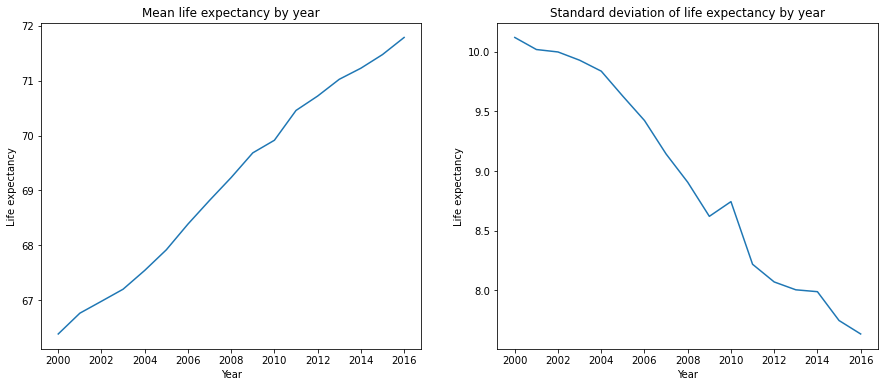

In [354]:
graph_attributes('life_expectancy', 'Life expectancy', 'Mean life expectancy by year', \
                 'Standard deviation of life expectancy by year')

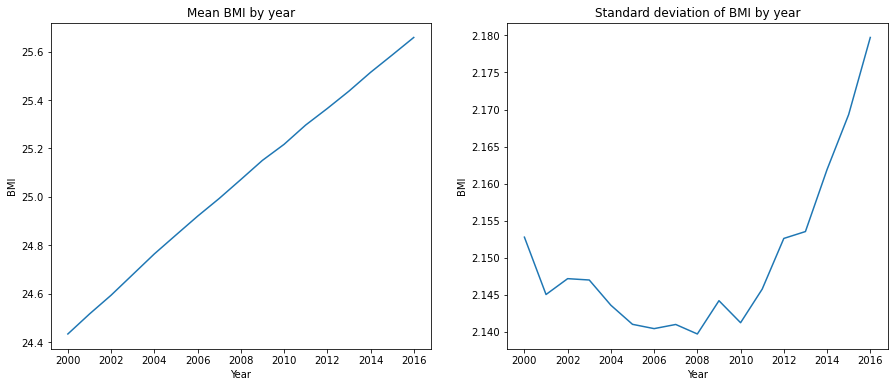

In [355]:
graph_attributes('bmi', 'BMI', 'Mean BMI by year', 'Standard deviation of BMI by year')

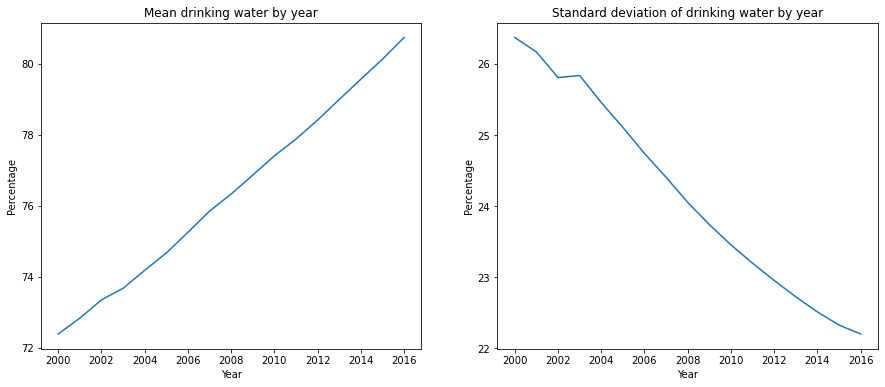

In [356]:
graph_attributes('drinking_water', 'Percentage', 'Mean drinking water by year', \
                 'Standard deviation of drinking water by year')

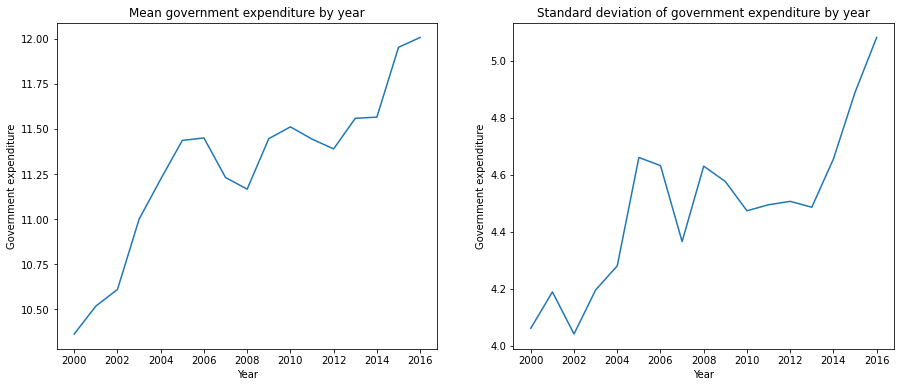

In [357]:
graph_attributes('government_expenditure', 'Government expenditure', 'Mean government expenditure by year', \
                 'Standard deviation of government expenditure by year')

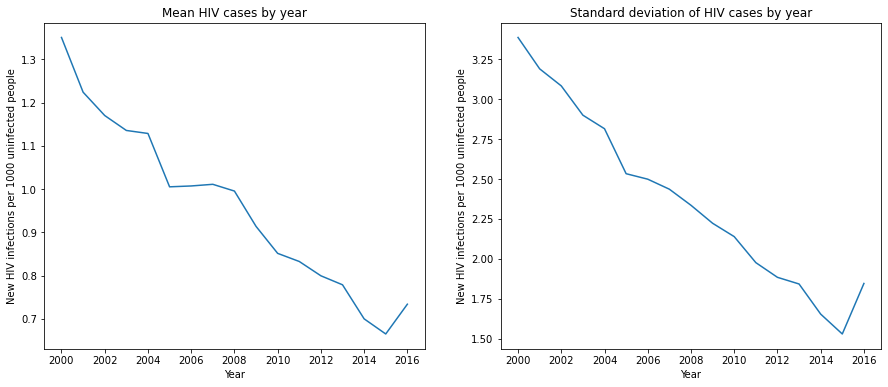

In [358]:
graph_attributes('HIV', 'New HIV infections per 1000 uninfected people', 'Mean HIV cases by year', \
                 'Standard deviation of HIV cases by year')

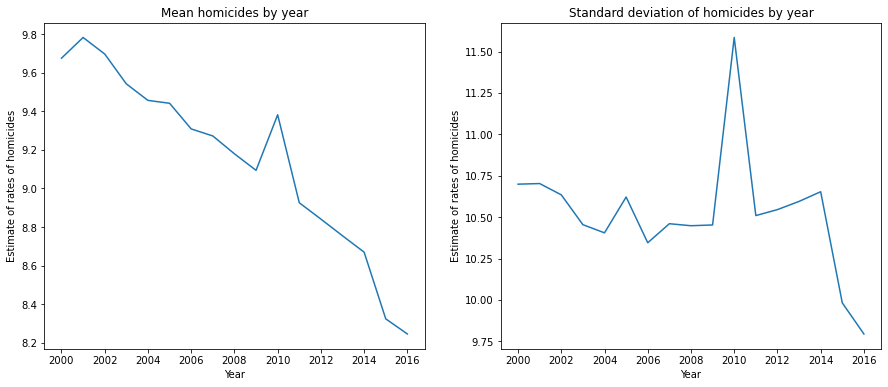

In [359]:
graph_attributes('homicides', 'Estimate of rates of homicides', 'Mean homicides by year', \
                 'Standard deviation of homicides by year')

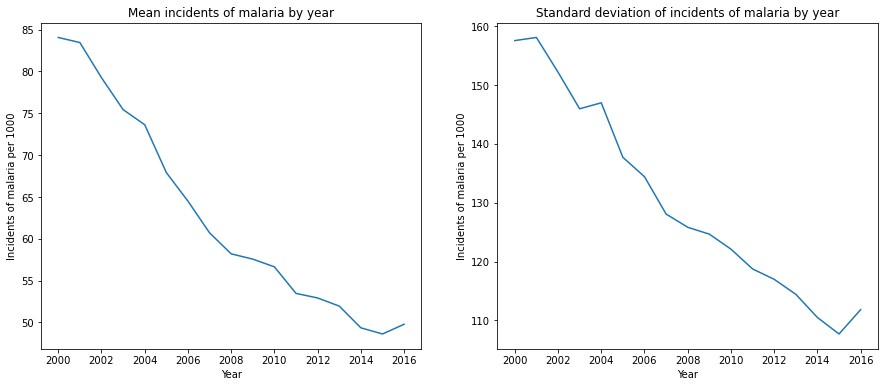

In [360]:
graph_attributes('malaria', 'Incidents of malaria per 1000', 'Mean incidents of malaria by year', \
                 'Standard deviation of incidents of malaria by year')

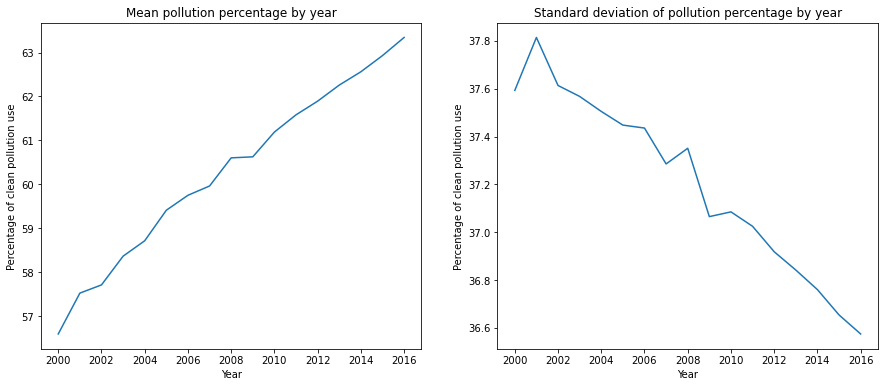

In [361]:
graph_attributes('pollution', 'Percentage of clean pollution use', 'Mean pollution percentage by year', \
                 'Standard deviation of pollution percentage by year')

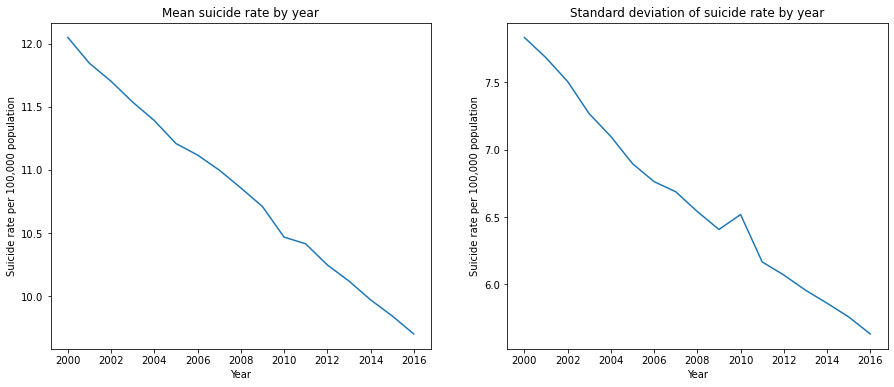

In [362]:
graph_attributes('suicides', 'Suicide rate per 100,000 population', 'Mean suicide rate by year', \
                 'Standard deviation of suicide rate by year')

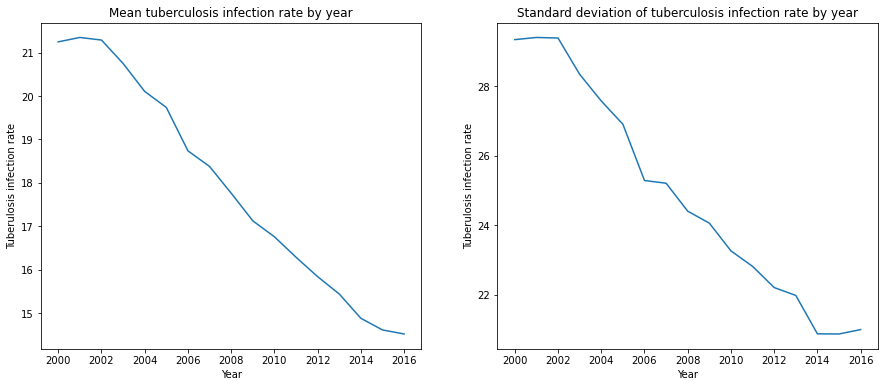

In [363]:
graph_attributes('tuberculosis', 'Tuberulosis infection rate', 'Mean tuberculosis infection rate by year', \
                 'Standard deviation of tuberculosis infection rate by year')

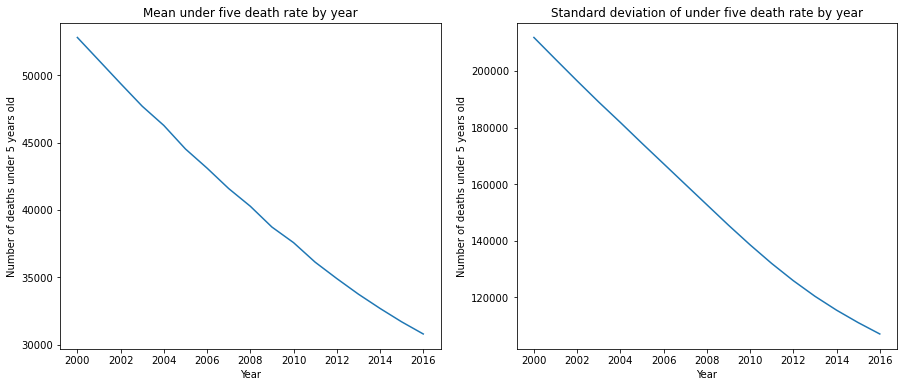

In [364]:
graph_attributes('under_five_deaths', 'Number of deaths under 5 years old', 'Mean under five death rate by year', \
                 'Standard deviation of under five death rate by year')

# Analysis, Hypothesis Testing, ML

In [365]:
df = df[['country', 'year', 'bmi', 'drinking_water', 'government_expenditure', 'HIV', 'homicides', 'malaria', \
        'pollution', 'suicides', 'tuberculosis', 'under_five_deaths', 'life_expectancy']]
df

country  year   bmi  \
0                                           Afghanistan  2016  23.4   
1                                           Afghanistan  2015  23.3   
2                                           Afghanistan  2014  23.2   
3                                           Afghanistan  2013  23.0   
4                                           Afghanistan  2012  22.9   
5                                           Afghanistan  2011  22.8   
6                                           Afghanistan  2010  22.7   
7                                           Afghanistan  2009  22.6   
8                                           Afghanistan  2008  22.5   
9                                           Afghanistan  2007  22.4   
10                                          Afghanistan  2006  22.3   
11                                          Afghanistan  2005  22.2   
12                                          Afghanistan  2004  22.1   
13                                          Afghanistan  2003  22.0   
14                                          Afghanistan  2002  21.9   
15                                          Afghanistan  2001  21.8   
16                                          Afghanistan  2000  21.7   
17                                              Albania  2016  26.7   
18                                              Albania  2015  26.6   
19                                              Albania  2014  26.5   
20                                              Albania  2013  26.4   
21                                              Albania  2012  26.3   
22                                              Albania  2011  26.2   
23                                              Albania  2010  26.1   
24                                              Albania  2009  26.0   
25                                              Albania  2008  25.9   
26                                              Albania  2007  25.8   
27                                              Albania  2006  25.7   
28                                              Albania  2005  25.6   
29                                              Albania  2004  25.5   
30                                              Albania  2003  25.4   
31                                              Albania  2002  25.3   
32                                              Albania  2001  25.2   
33                                              Albania  2000  25.2   
34                                              Algeria  2016  25.5   
35                                              Algeria  2015  25.5   
36                                              Algeria  2014  25.4   
37                                              Algeria  2013  25.3   
38                                              Algeria  2012  25.2   
39                                              Algeria  2011  25.1   
40                                              Algeria  2010  25.1   
41                                              Algeria  2009  25.0   
42                                              Algeria  2008  24.9   
43                                              Algeria  2007  24.8   
44                                              Algeria  2006  24.7   
45                                              Algeria  2005  24.7   
46                                              Algeria  2004  24.6   
47                                              Algeria  2003  24.5   
48                                              Algeria  2002  24.4   
49                                              Algeria  2001  24.4   
50                                              Algeria  2000  24.3   
51                                               Angola  2016  23.3   
52                                               Angola  2015  23.2   
53                                               Angola  2014  23.2   
54                                               Angola  2013  23.1   
55                                               Angola  2012  23.0   
5

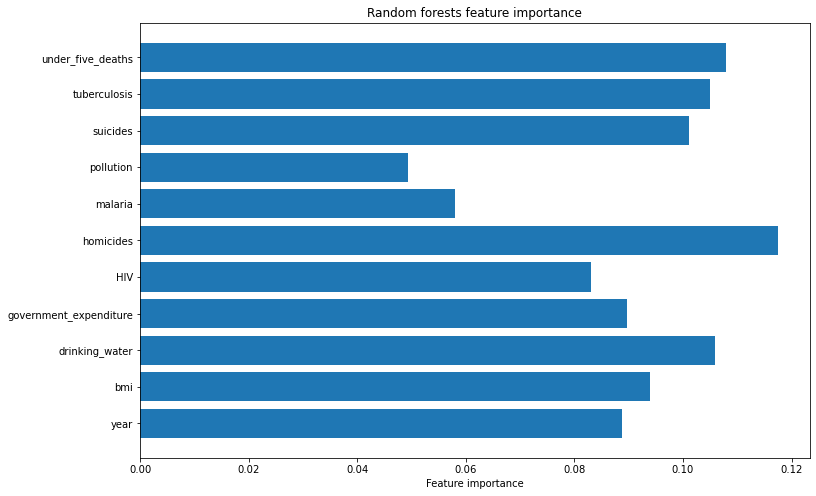

In [402]:
X = df.values[:, 1:-1]
y = df.values[:, -1].astype(int)

clf = RandomForestClassifier(n_estimators=100, criterion="gini")
clf = clf.fit(X, y)
clf.feature_importances_

plt.figure(figsize=(12, 8))
plt.title('Random forests feature importance')
plt.xlabel('Feature importance')

plt.barh(y=df.columns[1:-1], width=clf.feature_importances_)
plt.show()